# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd).

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random
import sklearn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-26 07:58:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  8.33MB/s    in 26s     

2021-10-26 07:58:59 (7.82 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [4]:
#проверила среднее и стандартное отклонение для переменных, чтобы понять 
#могут ли возникнуть проблемы с масштабом с учётом того, что сами признаки неинтерпретируемы
a = []
for i in df:
    a += [(df[i].mean(),df[i].std())]
pd.DataFrame(data = a, columns = ['mean', 'std'])

,mean,std
0,1998.397082,10.931046
1,43.387126,6.067558
2,1.289554,51.580351
3,8.658347,35.268585
4,1.164124,16.322790
...,...,...
86,17.669213,114.427905
87,-26.315336,173.977336
88,4.458641,13.346557
89,20.035136,185.558247


In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [6]:
from sklearn import preprocessing
#стандартизирую по отдельности данные и таргет
scaler = preprocessing.StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scaler2 = preprocessing.StandardScaler()
scaler2.fit(y_train.reshape(-1, 1))

StandardScaler(copy=True, with_mean=True, with_std=True)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучим `Ridge` регрессию и посчитаем качество при наилучшем константном прогнозе.

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [8]:
model_r = Ridge()
model_r.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [9]:
#неконстантный прогноз
R_y_pred = model_r.predict(X_test)
from math import sqrt
from statistics import mean, median
print(sqrt(mean_squared_error(y_train, model_r.predict(X_train))))
print(sqrt(mean_squared_error(y_test, R_y_pred)))

#константный прогноз
pred1 = [mean(y_train)]*X_test.shape[0]
print(sqrt(mean_squared_error(y_test, pred1))) #по среднему

pred2 = [median(y_train)]*X_test.shape[0]
print(sqrt(mean_squared_error(y_test, pred2))) #на всякий случай попробовала по медиане, посмотрев на визуализацию

9.552822967970323
9.510160820470436
10.863228020678134
11.403668567118597


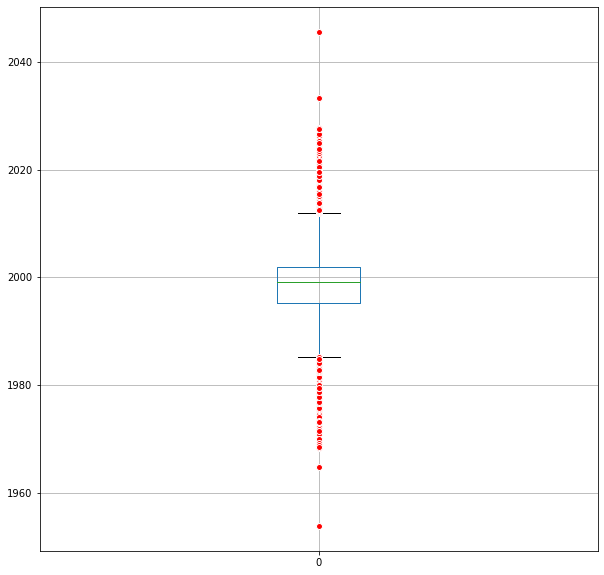

In [10]:
#визуализация прогноза (на всякий случай, хотелось посмотреть, насколько скучены значения)
vis = pd.DataFrame(R_y_pred)
plt.figure(figsize=(10, 10))
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
vis.boxplot(meanline = True, flierprops = red_circle)

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

In [11]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [12]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
        
    def __len__(self):
        return self.X.size()[0]
    
    def __getitem__(self, idx):
        return self.X[idx,:], self.y[idx]

In [13]:
train_set = MyDataset(X_train,y_train)
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=256,
                                           shuffle = True
                                           )

test_set = MyDataset(X_test,y_test)
test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size=256)

In [58]:
set_random_seed(50)

In [59]:
model1 = nn.Sequential(
    nn.Linear(90, 100),
    nn.LeakyReLU(),
    nn.Dropout(0.3),#добавлено на третьем эксперименте
    nn.Linear(100, 80),
    nn.LeakyReLU(),
    nn.Dropout(0.1),#добавлено на третьем эксперименте
    nn.Linear(80, 1)
)

optimizer = torch.optim.Adam(model1.parameters(), lr=0.0003) #взяла самое малое значение из диапазона, что давали в канале
criterion = nn.MSELoss()

In [60]:
def train(model, optimizer, criterion, train_loader, test_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
    '''
    #тут ориентировалась чисто по семинарам; наверное, можно сделать более эффективно, но я с трудом представляю как
    loss_train = []                      #создаем объект, в котором будет храниться ошибка по трейну
    loss_test = []
    for epoch in tqdm(range(10)):        #в ходе первого эксперимента использую 10 эпох
        model.train()                    #говорим модели, что она учится
        local_loss = 0                   #создаем переменную, которая будет копить ошибку в ходе обучения
        preds_ep = torch.Tensor()
        for X_train, y_train in tqdm(train_loader):
            y_train = torch.tensor(scaler2.transform(y_train.reshape(-1,1)),dtype = torch.float) #нормализация таргета
            optimizer.zero_grad() 
            y_pred = model(X_train)      #делаем предсказания
            loss = criterion(y_pred,y_train) #считаем ошибку
            loss.backward()              #отправляем градиент backqad propagation
            optimizer.step()             #обновление параметров
            local_loss += loss.item() * y_pred.shape[0] * scaler2.scale_ ** 2 #тут как раз для подсчёта ошибки умножаем на шкалу нормализации 
    
        local_loss /= len(train_set)    #считаем среднюю ошибку на сете
        loss_train += [local_loss]      #добавляем получившиеся значения в ранее созданный объек для ошибки
        
        loss_test += test(model, criterion, test_loader)['loss_test']
    
    
    loss_train = np.sqrt(loss_train)    #RMSE 
    loss_test = np.sqrt(loss_test)
    
    fig = plt.figure()
    plt.plot(range(len(loss_train)), loss_train, label='train')
    plt.plot(range(len(loss_test)), loss_test, label='test')
    plt.xlabel('epoch')
    plt.ylabel('RMSE')
    plt.grid()
    plt.legend()
    plt.show()
    
    print(loss_test.min())
    
def test(model, criterion, test_loader):
    model.eval() #сообщаем модели, что теперь она тренируеся                         
    loss_test = [] #аналогичный объект для хранения ошибки на тест
    local_loss = 0 #ошибка на батче
    predicts = torch.empty(0) #объект для хранения предсказаний
    with torch.no_grad():
        for X_test, y_test in tqdm(test_loader):
            y_pred = model(X_test)
            y_pred = torch.tensor(scaler2.inverse_transform(y_pred), dtype=torch.float).squeeze()
            loss = criterion(y_pred,y_test)
            local_loss += loss.item()*y_pred.shape[0]
            predicts = torch.cat((predicts, y_pred),dim = 0)
    local_loss /= len(test_set)
    loss_test += [local_loss]
    
    return {'predicts': predicts,'loss_test': loss_test}

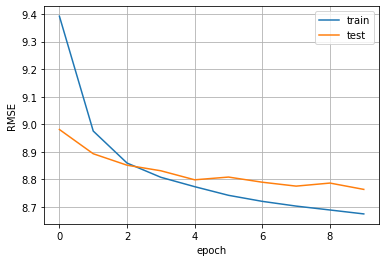

8.763467185853928


In [61]:
train(model1, optimizer, criterion,train_loader, test_loader)

In [1]:
assert test(model1, criterion, test_loader)['predicts'].shape[0] == y_test.shape[0]

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

# Отчёт

## 1 эксперимент:
Первый эксперимент представлен моделью из четырех линейных слоев, разделяемых нелинейностью (ReLU).  В значениях количества нейронов на вход и выход я ориентировалась на статью по ссылке (https://detailed-tutorials.sthakur.work/all-tutorials/predicting-song-release-year-pytorch/). 
Batch size пробовала по степеням двойки. Для начала взяла 128, потому что иначе батчей слишком много и обучение очень затягивается.

В качестве optimizer использовался Adam (тоже под влиянием статей, семинара про оптимизацию, и я уже не отказывалась от него после сообщения в канале). 

Learning rate пробовала установить на уровне 0,0001 (такой пример был на pytorch.org и я решила с него начать) и, после сообщения в канале 0,0003.
С lr = 0,0001 и batch size 128 (RMSE на тесте: 8.90422437824825, время: 02:12), 256 (RMSE: 8.923514468466323, время: 01:33) и 512 (RMSE: 8.955982711274014,время: 01:25).

С lr = 0,0003 и batch size 128 (RMSE на тесте: 8.870037373176846, время: 02:03), 256 (RMSE: 8.87559607517349, время: 01:45) и 512 (RMSE: 8.884426886871479, время: 01:21).

Выбрала сочетание batch_size = 256 и lr = 0,0003

Использовалось 10 эпох

## 2 эксперимент

Я решила попробовать расширить количество нейронов в слое до 100, поэтому несколько изменила архитектуру модели. При этом решила отказаться от одного из слоев (тут тоже проверяю его ценность в модели)
Эта архитектура, за исключением дропаутов, сохранена в актуальной ячейке с моделью. 

Три полносвязных слоя и две нелинейности ReLu.

Параметры batch_size и lr сохранила с предыдущего эксперимента

1) с четырьмя линейными слоями (90/100/20/10/1) RMSE: 8.821631216748168, время: 01:36 
2) с тремя линейными слоями (90/100/20/1) RMSE: 8.80325582965728, время: 01:32

Качество и время улучшилось, так что продолжаю дальше с этой архитектурой (три линейных слоя)

## 3 эксперимент

Добавила дропауты

1) Сначала добавила один дропаут с дефолтным p=0,5
RMSE: 8.801039527613721, время: 01:34 стало чуть-чуть лучше

2) Добавяю второй дропаут с таким же p
RMSE: 8.862070930719598, время: 01:39 стало хуже

3) Решила сократить p до 0,3
RMSE: 8.779143119164855, время: 01:37 стало лучше

4) Пробую сократить на одном слое, чтобы не слишком облегчать жизнь модели (итого два дропаута с p1 = 0.3 p2 = 0.1)
RMSE: 8.76976515276405, время: 02:44 время увеличилось ощутимо, но качество стало лучше

## Итоговая модель
- Три линейных слоя 90/100/80/1 (решила еще немного поэкспериментировать с шириной слоев и подумала, что може), разделенных нелинейностью LeakyReLu (попробовала по наведению сообщения из канала)
- Два дропаута (0.3) и (0.1) 
- оптимизатор Adam, lr = 0,0003
- 10 эпох
- размер батча 256
- Качество на тесте: 8.763 (см. рисунок выше)